# Mugration Analysis

---
## Questions

### 1. ... Biovar...phylo branch

---
## Setup

### Module Imports

In [2]:
from Bio import Phylo
from treetime.utils import parse_dates
from treetime import wrappers

import copy
import os
import sys
import IPython
import io

import pandas as pd
import numpy as np
import math

from geopy.distance import great_circle

import matplotlib.pyplot as plt
from matplotlib import colors, lines, patches, gridspec
import seaborn as sns

### Input File Paths

In [3]:
tree_path = "../../docs/results/latest/branch_support/branch-support.xml"
tree_df_path = "../../docs/results/latest/branch_support/branch-support.tsv"
metadata_path = "../../docs/results/2021-01-11/metadata/metadata.txt"
outdir = "../../docs/results/latest/treetime/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### Variables

In [4]:
# Metadata
NAME_COL = "Sample"
DATES_COL = "Date"
ATTRIBUTE_LIST = ["Branch_Major", "Branch_Minor"]
#ATTRIBUTE = "Country"
#ATTRIBUTE = "Province"
#ATTRIBUTE = "Biovar"
ATTRIBUTE = "Branch_Major"
#ATTRIBUTE = "Branch_Minor"
NO_DATA_CHAR = "NA"

# Optional, lat, lon
ATTRIBUTE_LAT = ATTRIBUTE + "Lat"
ATTRIBUTE_LON = ATTRIBUTE + "Lon"
DIST_UNIT = "km"

# Confidence Thresholds
MUG_CONF_THRESH = 0.95

### Plotting Configuration

In [5]:
# Colors
HIGH_COL = "red"
LOW_COL = "black"
TERM_COL = "grey"
THRESH_COL = "blue"
COLOR_PAL = "rainbow"
COLBAR_MAX_ROW = 10

# Graphics
figsize=(6.4,4.8)
figsize_alt=(9.6,4.8)
dpi=400

# Font
SM_FONT = 5
MED_FONT = 8
LG_FONT = 10

plt.rc('font', size=SM_FONT)          # controls default text sizes
plt.rc('figure', titlesize=LG_FONT)  # fontsize of the figure title
#plt.rc('axes', labelsize=MED_FONT)    # fontsize of the x and y labels

# Lines
plt.rc('lines', linewidth=1)

---
## Analysis

### Read Input Tree and Dataframe

In [6]:
tree_div = Phylo.read(tree_path, "phyloxml")
tree_df = pd.read_csv(tree_df_path, sep='\t')
tree_df.set_index("Name", inplace=True)

### Parse Metadata

In [7]:
# Parse the metadata
metadata_df = pd.read_csv(metadata_path, sep='\t')

# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

# Tell treetime which column is the taxon name
#if NAME_COL in metadata_df.columns:
#    taxon_name = NAME_COL

# set the metadata index
metadata_df.set_index(NAME_COL, inplace=True)
print(metadata_df)

                                    Strain  Date DateBP Country   Province  \
Sample                                                                       
GCA_009669545.1_ASM966954v1_genomic  42126  2006    -15   China   Xinjiang   
GCA_009669555.1_ASM966955v1_genomic  42123  2005    -16   China   Xinjiang   
GCA_009669565.1_ASM966956v1_genomic  42118  2005    -16   China   Xinjiang   
GCA_009669605.1_ASM966960v1_genomic  42117  2005    -16   China   Xinjiang   
GCA_009669625.1_ASM966962v1_genomic  42116  2005    -16   China   Xinjiang   
...                                    ...   ...    ...     ...        ...   
IP557                                IP557  1963    -58    Iran  Kurdistan   
IP282                                   NA    NA     NA      NA         NA   
IP542                                IP542  1952    -69   Kenya         NA   
IP562                                IP562  1947    -74    Iran  Kurdistan   
IP579                                IP579  1908   -113   India 

### Add Metadata to Tree Dataframe

In [8]:
for attr in ATTRIBUTE_LIST:
    if attr in metadata_df.columns:
        # Initialize new column to all NA
        tree_df[attr] = [NO_DATA_CHAR for row in range(0,len(tree_df))]
        # add metadata to tree data frame
        for t in tree_div.get_terminals():         
            if t.name in metadata_df.index:
                tree_df[attr][t.name] = metadata_df[attr][t.name]       
print(tree_df)

                UFboot   aLRT Branch_Support_Color  Branch_Length  \
Name                                                                
NODE0             96.0   77.8                black            NaN   
NODE1            100.0   98.2                  red   3.027200e-06   
NODE2            100.0  100.0                  red   9.680700e-06   
NODE3            100.0  100.0                  red   7.425800e-06   
NODE4            100.0   95.4                  red   1.172900e-06   
...                ...    ...                  ...            ...   
SAMEA104233049     NaN    NaN                 grey   6.600000e-08   
SAMEA104233047     NaN    NaN                 grey   2.350000e-08   
SAMEA104233050     NaN    NaN                 grey   7.368000e-07   
SAMEA104233046     NaN    NaN                 grey   2.350000e-08   
SAMEA3541827       NaN    NaN                 grey   3.436500e-06   

               Branch_Major Branch_Minor  
Name                                      
NODE0           

/opt/conda/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
# Map the taxon name to the attribute for mugration analysis
leaf_to_attr = {}

for attr in ATTRIBUTE_LIST:
    leaf_to_attr[attr] = {sample:str(data[attr]) for sample,data in metadata_df.iterrows()
                    if data[attr]!=NO_DATA_CHAR and data[attr]}

print(leaf_to_attr)

{'Branch_Major': {'GCA_009669545.1_ASM966954v1_genomic': '0.ANT', 'GCA_009669555.1_ASM966955v1_genomic': '0.ANT', 'GCA_009669565.1_ASM966956v1_genomic': '0.ANT', 'GCA_009669605.1_ASM966960v1_genomic': '0.ANT', 'GCA_009669625.1_ASM966962v1_genomic': '0.ANT', 'GCA_009669675.1_ASM966967v1_genomic': '0.ANT', 'GCA_009669635.1_ASM966963v1_genomic': '0.ANT', 'GCA_009669665.1_ASM966966v1_genomic': '0.ANT', 'GCA_009669725.1_ASM966972v1_genomic': '0.ANT', 'GCA_009669715.1_ASM966971v1_genomic': '0.ANT', 'GCA_009669705.1_ASM966970v1_genomic': '0.ANT', 'GCA_009669775.1_ASM966977v1_genomic': '0.ANT', 'GCA_009669765.1_ASM966976v1_genomic': '0.ANT', 'GCA_009669805.1_ASM966980v1_genomic': '0.ANT', 'GCA_009669825.1_ASM966982v1_genomic': '0.ANT', 'GCA_009669835.1_ASM966983v1_genomic': '0.ANT', 'GCA_009669845.1_ASM966984v1_genomic': '0.ANT', 'GCA_009669875.1_ASM966987v1_genomic': '0.ANT', 'GCA_009669905.1_ASM966990v1_genomic': '0.ANT', 'GCA_009669955.1_ASM966995v1_genomic': '0.ANT', 'GCA_009669925.1_ASM96

---
## Mugration

In [9]:
"""
# Optional: simplify the Mictorus biovar
for leaf in leaf_to_attr:
    leaf_attr = leaf_to_attr[leaf]
    if leaf_attr in ["Ulegeica", "Altaica", "Talassica", "Hissarica", "Xilingolensis", "Caucasica"]:
        leaf_to_attr[leaf] = "Microtus"""

'\n# Optional: simplify the Mictorus biovar\nfor leaf in leaf_to_attr:\n    leaf_attr = leaf_to_attr[leaf]\n    if leaf_attr in ["Ulegeica", "Altaica", "Talassica", "Hissarica", "Xilingolensis", "Caucasica"]:\n        leaf_to_attr[leaf] = "Microtus'

In [26]:
mug_dict = {}

for attr in ATTRIBUTE_LIST:
    mug_dict[attr] = {}
    # Make a copy of the input tree
    mug_dict[attr]["tree_div"] = copy.deepcopy(tree_div)
    # Map the taxon name to the attribute for mugration analysis
    mug_dict[attr]["leaf_to_attr"] = {sample:str(data[attr]) for sample,data in metadata_df.iterrows()
                    if data[attr]!=NO_DATA_CHAR and data[attr]}    
    # Make blank dicts for the mugration output
    mug_dict[attr]["tree_mug"] = {}
    mug_dict[attr]["letter_to_state"] = {}
    mug_dict[attr]["reverse_alphabet"] = {}
    mug_dict[attr]["unique_states"] = {}
    
print(mug_dict)

{'Branch_Major': {'tree_div': Phylogeny(rooted=False), 'leaf_to_attr': {'GCA_009669545.1_ASM966954v1_genomic': '0.ANT', 'GCA_009669555.1_ASM966955v1_genomic': '0.ANT', 'GCA_009669565.1_ASM966956v1_genomic': '0.ANT', 'GCA_009669605.1_ASM966960v1_genomic': '0.ANT', 'GCA_009669625.1_ASM966962v1_genomic': '0.ANT', 'GCA_009669675.1_ASM966967v1_genomic': '0.ANT', 'GCA_009669635.1_ASM966963v1_genomic': '0.ANT', 'GCA_009669665.1_ASM966966v1_genomic': '0.ANT', 'GCA_009669725.1_ASM966972v1_genomic': '0.ANT', 'GCA_009669715.1_ASM966971v1_genomic': '0.ANT', 'GCA_009669705.1_ASM966970v1_genomic': '0.ANT', 'GCA_009669775.1_ASM966977v1_genomic': '0.ANT', 'GCA_009669765.1_ASM966976v1_genomic': '0.ANT', 'GCA_009669805.1_ASM966980v1_genomic': '0.ANT', 'GCA_009669825.1_ASM966982v1_genomic': '0.ANT', 'GCA_009669835.1_ASM966983v1_genomic': '0.ANT', 'GCA_009669845.1_ASM966984v1_genomic': '0.ANT', 'GCA_009669875.1_ASM966987v1_genomic': '0.ANT', 'GCA_009669905.1_ASM966990v1_genomic': '0.ANT', 'GCA_009669955.1

### Run mugration to capture log

In [28]:
for attr in ATTRIBUTE_LIST:
    print("Running mugration for attribute: {}".format(attr))
    # Initialize stdout capture
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout
    
    # Run mugration
    mug, letter_to_state, reverse_alphabet = wrappers.reconstruct_discrete_traits(mug_dict[attr]["tree_div"], 
                                                                     traits=mug_dict[attr]["leaf_to_attr"], 
                                                                     missing_data=NO_DATA_CHAR,
                                                                     #missing_data="nan",
                                                                     #pc=pc, 
                                                                     #sampling_bias_correction=sampling_bias_correction, 
                                                                     verbose=4, 
                                                                     #weights=params.weights
                                                                    )
    mug_dict[attr]["tree_mug"] = mug
    mug_dict[attr]["letter_to_state"] = letter_to_state
    mug_dict[attr]["reverse alphabet"] = reverse_alphabet
    mug_dict[attr]["unique_states"] = sorted(letter_to_state.values())
    
    # Save stdout to file
    output = new_stdout.getvalue()
    out_path = os.path.join(outdir, "mug_{}.log".format(attr.lower())) 
    with open(out_path, "w") as file:
        file.write(output)
    # Restore stdout
    sys.stdout = old_stdout

Running mugration for attribute: Branch_Major
Running mugration for attribute: Branch_Minor


### Add mugration to dataframe

In [47]:
for attr in ATTRIBUTE_LIST:
    print(attr)
    # Initialize empty values for the new mugration attribute and its confidence
    tree_df["Mugration_" + attr] = [NO_DATA_CHAR for row in range(0,len(tree_df))]
    tree_df["Mugration_" + attr + "_Confidence"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]    
    
    tree_mug = mug_dict[attr]["tree_mug"].tree
    unique_states = mug_dict[attr]["unique_states"]

    # Iterate through the nodes in the tree
    for c in tree_mug.find_clades():
        # Store the name and confidence for the state with the most support
        state_max_name = mug_dict[attr]["letter_to_state"][c.cseq[0]]
        state_conf_list = c.marginal_profile[0]
        state_max_conf = max(state_conf_list)
        c.other = []

        # Store all the states and confidence values
        for state_name,state_conf in zip(unique_states, state_conf_list):
            attr_other = Phylo.PhyloXML.Other(tag=state_name, value="{:0.4f}".format(state_conf), namespace=attr)
            c.other.append(attr_other)

        # Store the Maximum assigned value
        attr_other = Phylo.PhyloXML.Other(tag=state_max_name, value="{:0.4f}".format(state_max_conf), namespace=attr + "_assign")
        c.other.append(attr_other)
    
        if c.name in tree_df.index:
            tree_df["Mugration_" + attr][c.name] = state_max_name
            tree_df["Mugration_" + attr + "_Confidence"][c.name] = state_max_conf

print(tree_df)

Branch_Major


/opt/conda/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Branch_Minor
                UFboot   aLRT Branch_Support_Color  Branch_Length  \
Name                                                                
NODE0             96.0   77.8                black            NaN   
NODE1            100.0   98.2                  red   3.027200e-06   
NODE2            100.0  100.0                  red   9.680700e-06   
NODE3            100.0  100.0                  red   7.425800e-06   
NODE4            100.0   95.4                  red   1.172900e-06   
...                ...    ...                  ...            ...   
SAMEA104233049     NaN    NaN                 grey   6.600000e-08   
SAMEA104233047     NaN    NaN                 grey   2.350000e-08   
SAMEA104233050     NaN    NaN                 grey   7.368000e-07   
SAMEA104233046     NaN    NaN                 grey   2.350000e-08   
SAMEA3541827       NaN    NaN                 grey   3.436500e-06   

               Branch_Major Branch_Minor Mugration_Branch_Major  \
Name                  

---
## Plotting

### Mugration Boxplots

Branch_Major
Branch_Minor


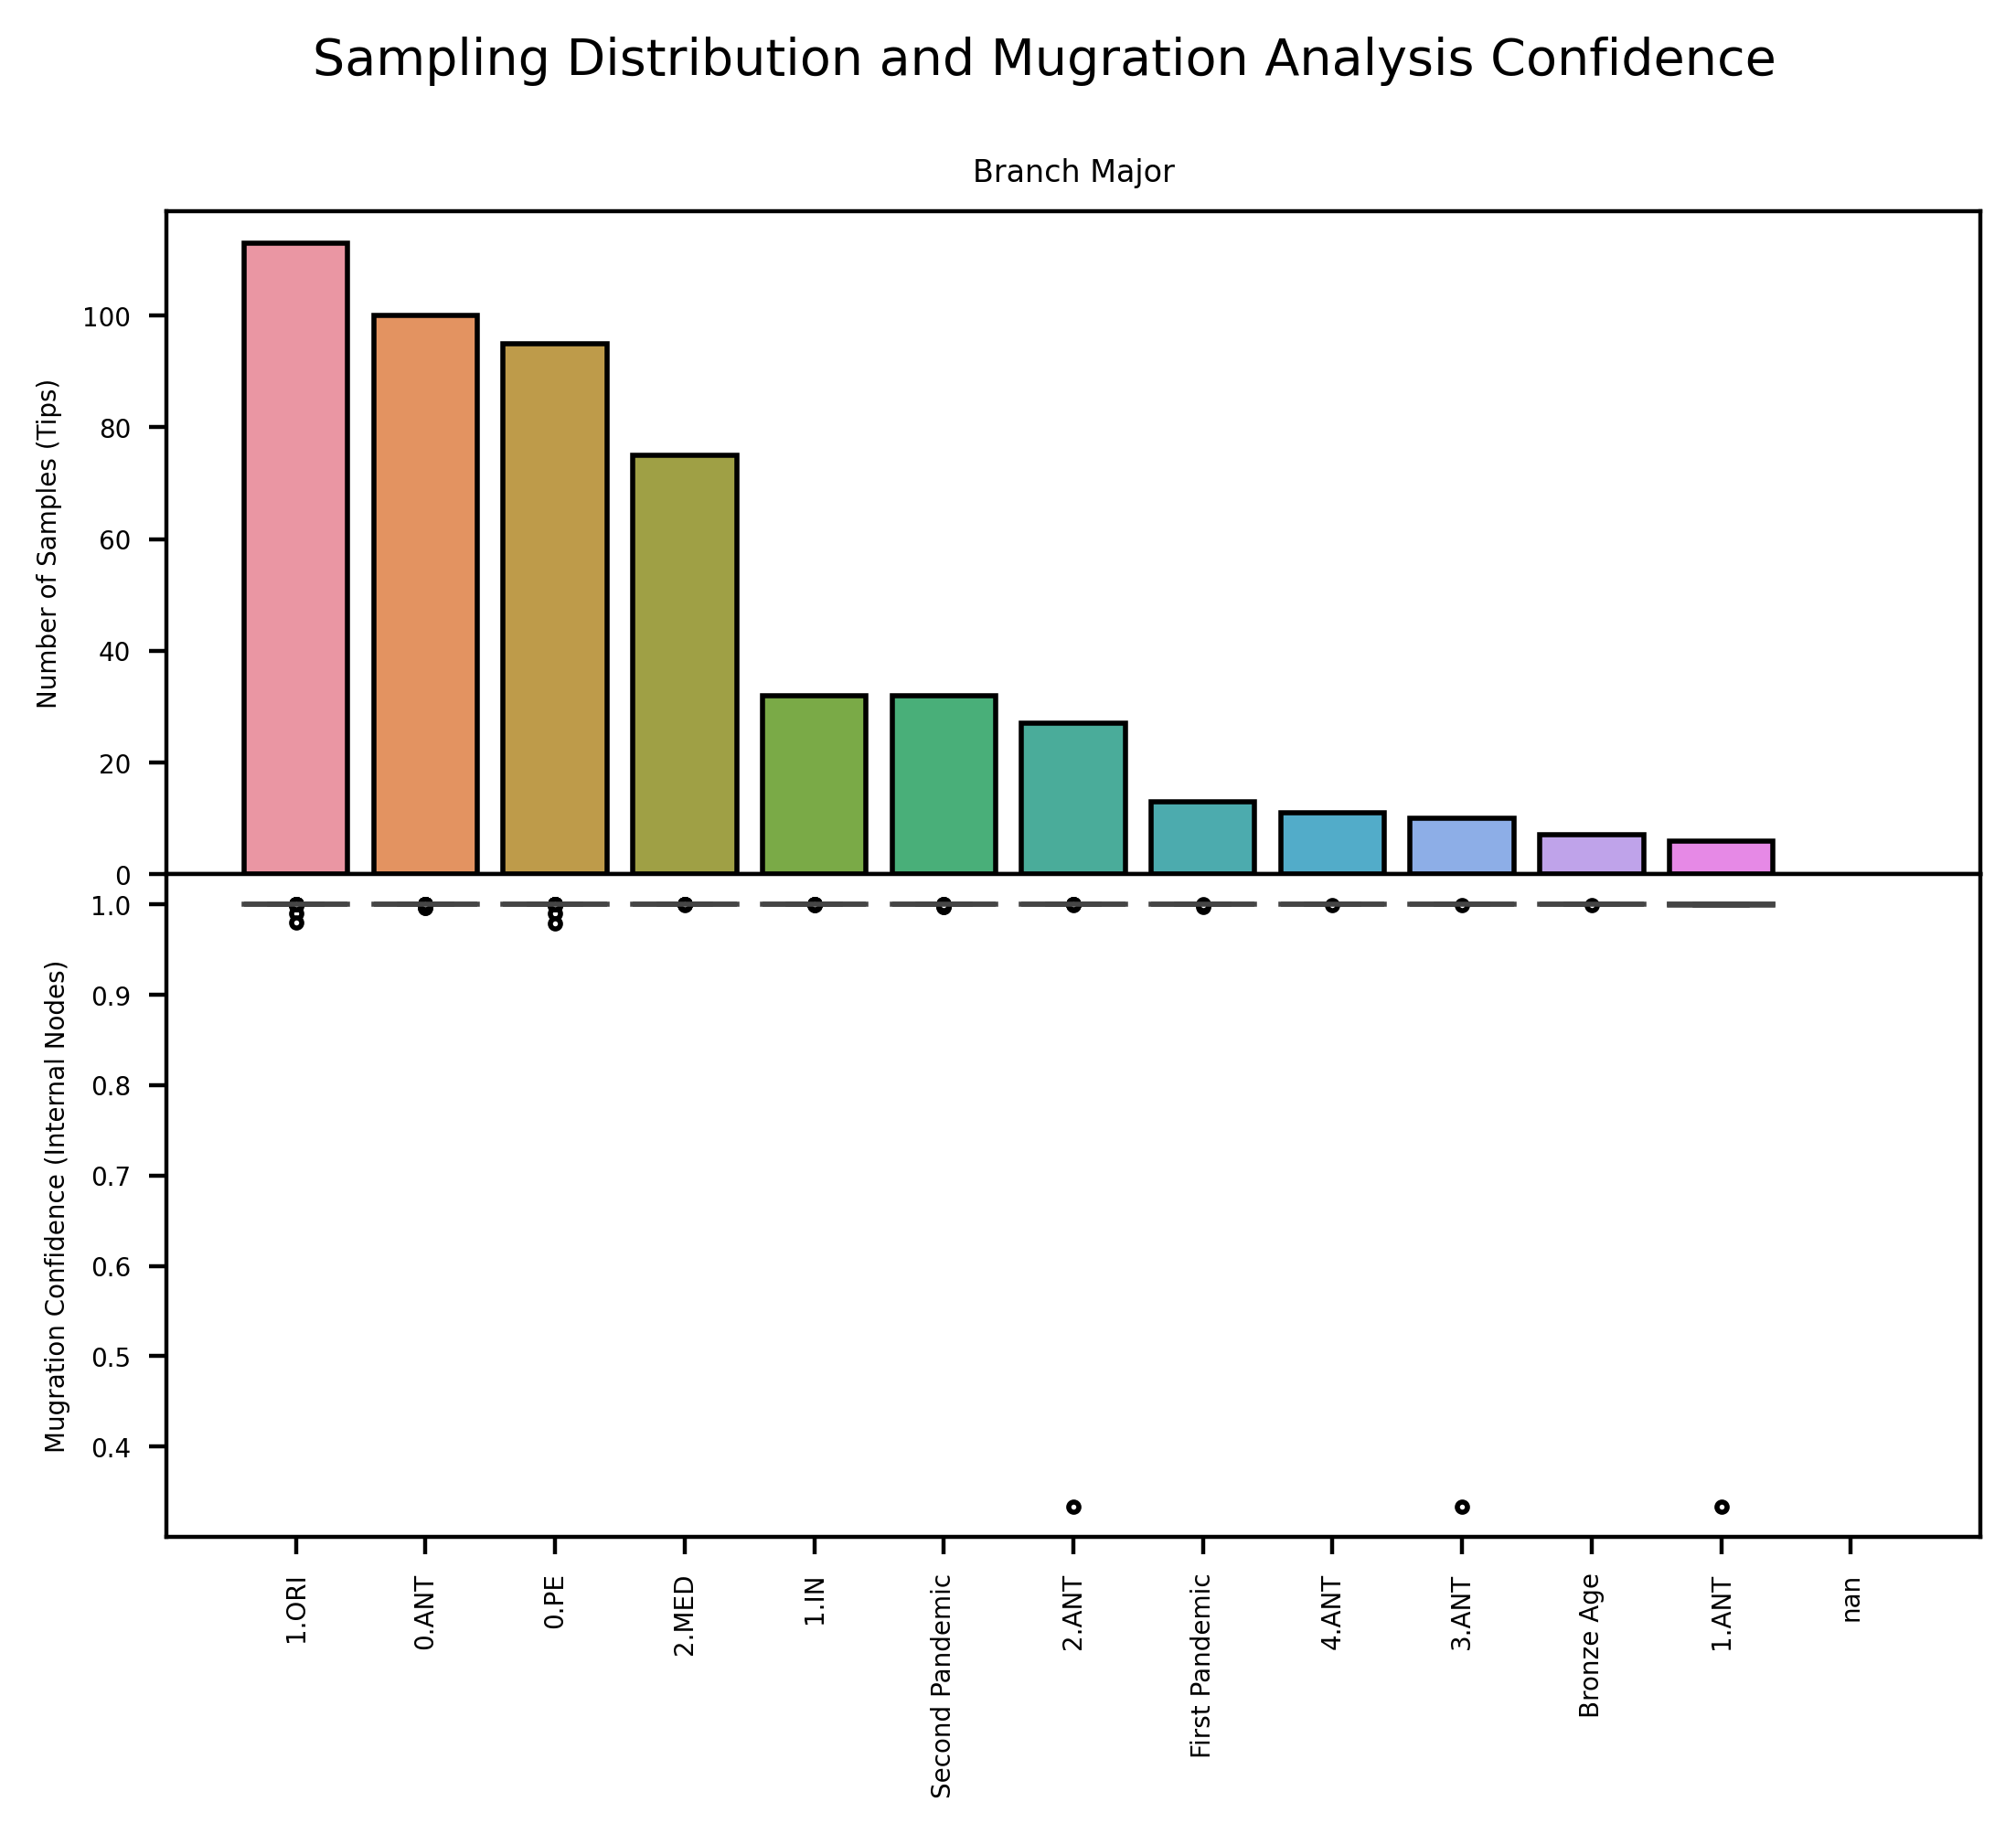

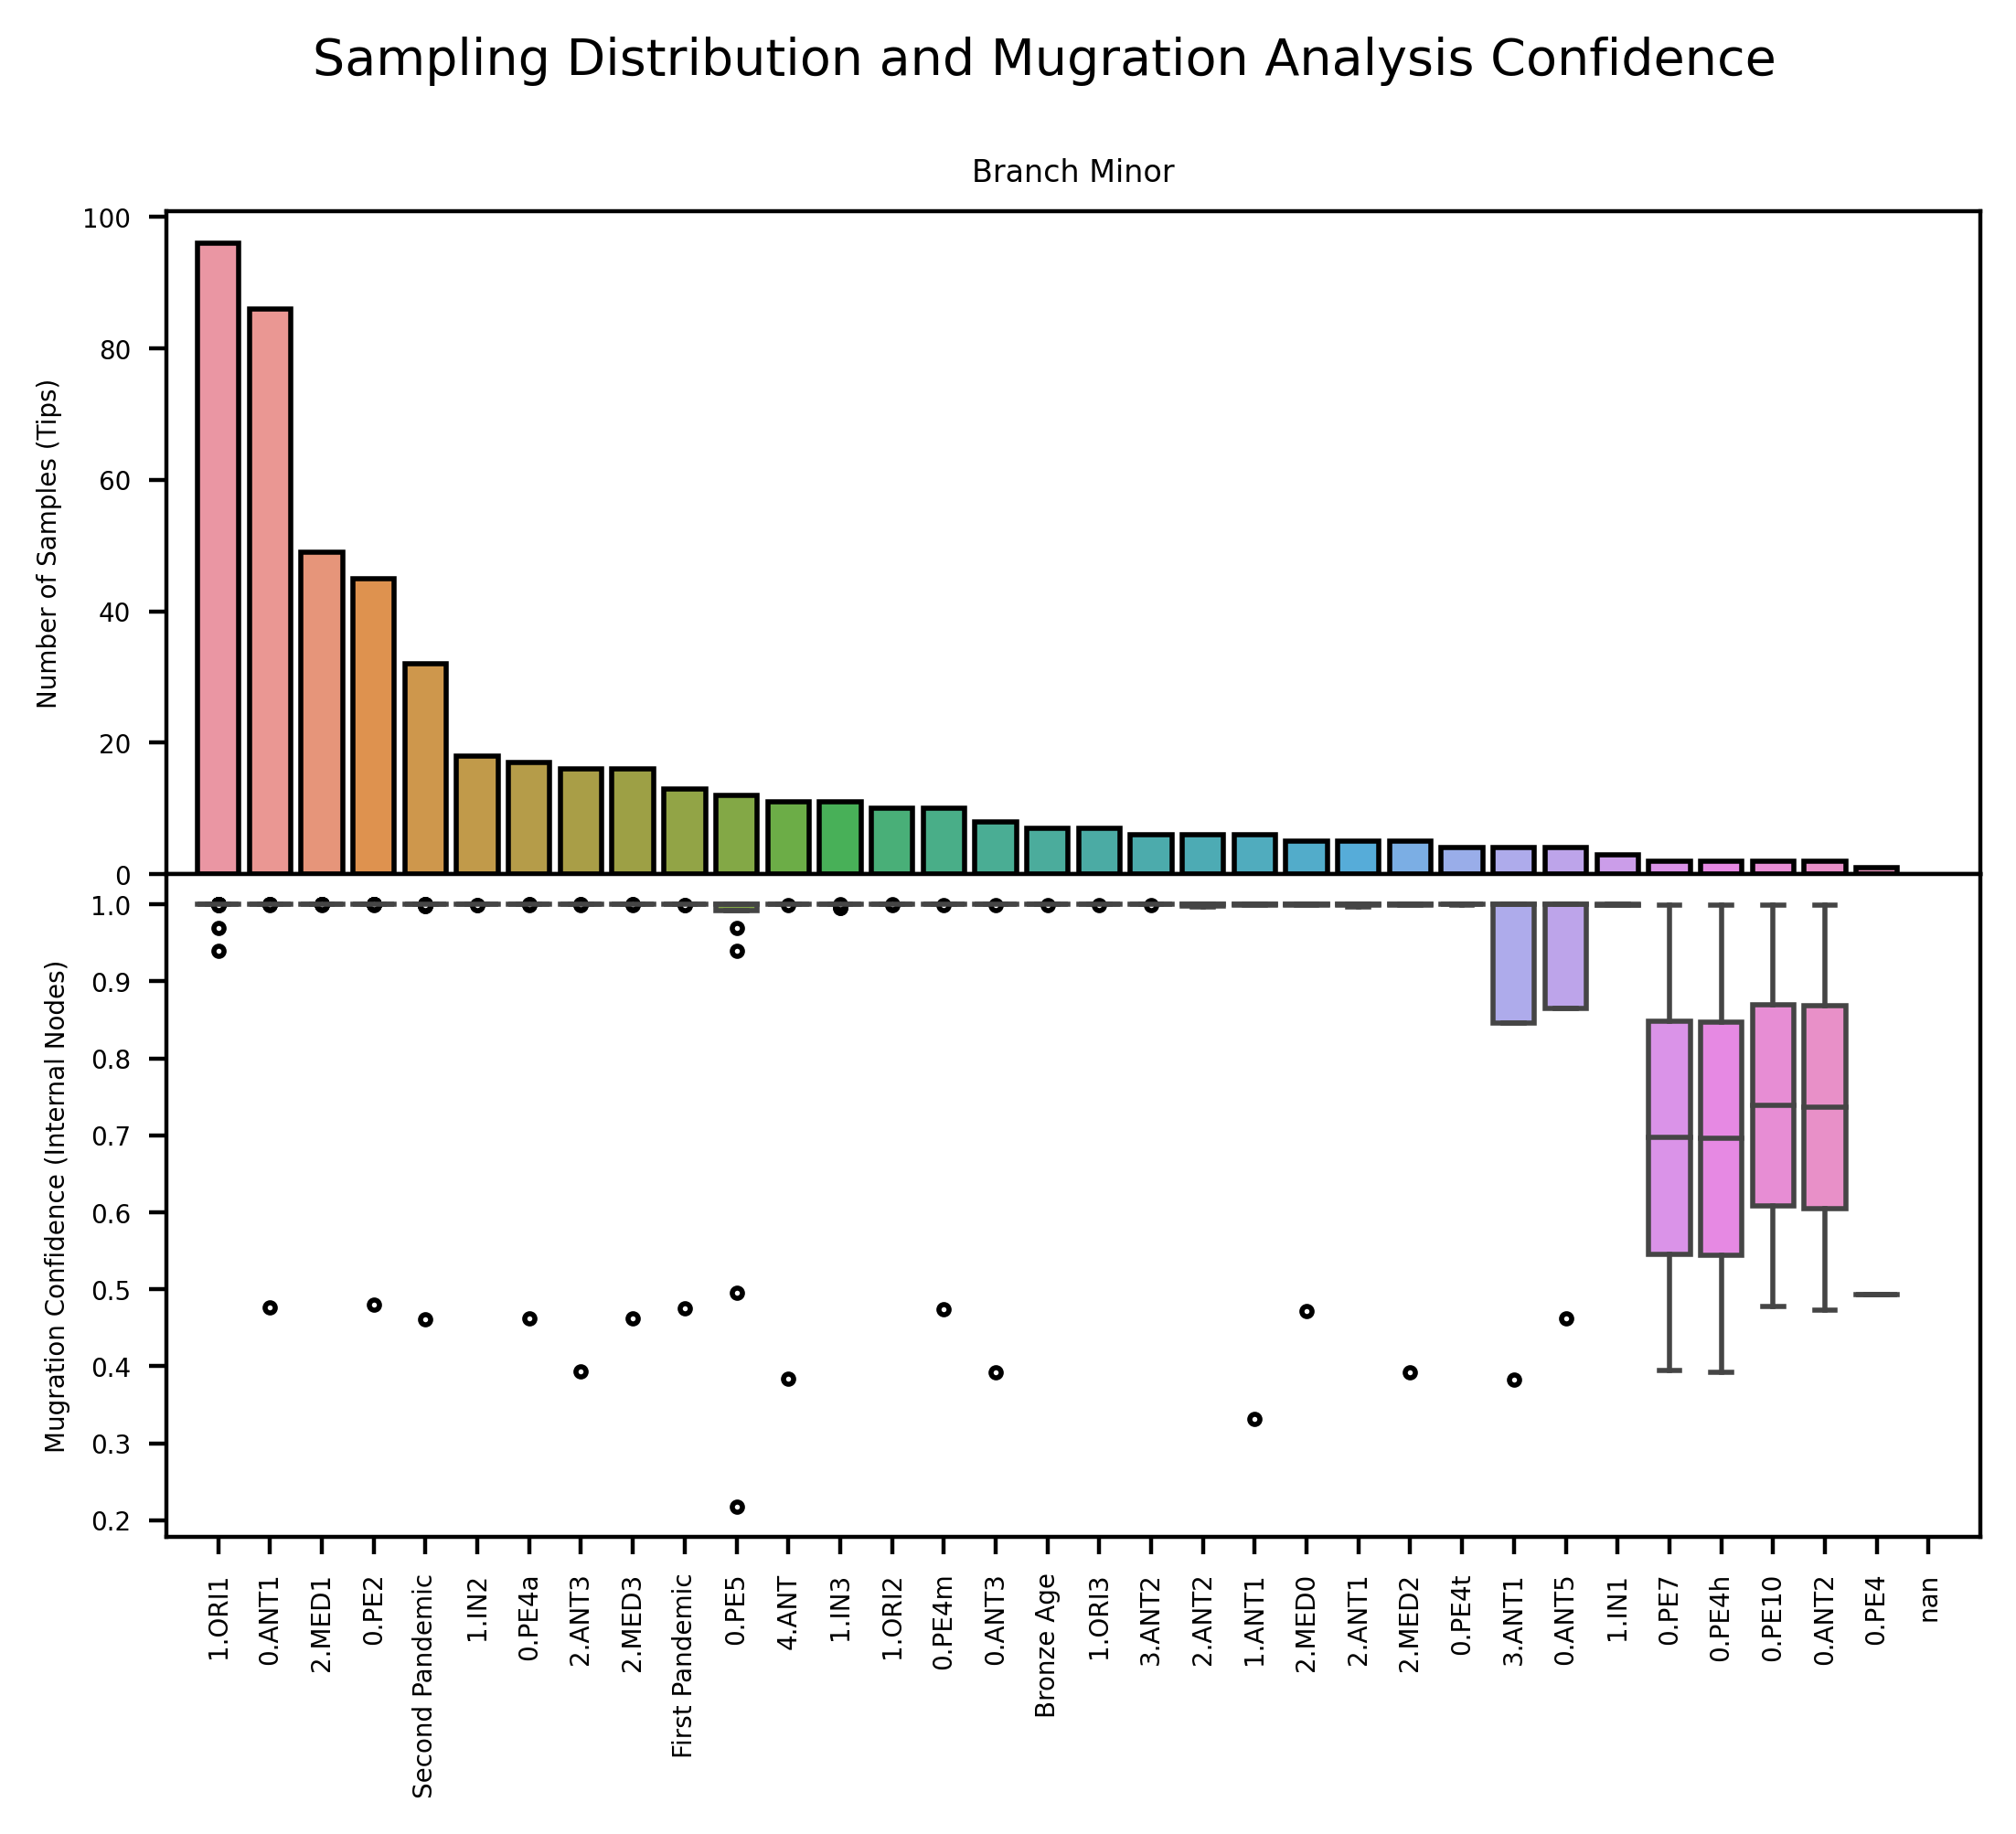

In [65]:
for attr in ATTRIBUTE_LIST:
    fig, (ax1, ax2) = plt.subplots(2, 
                               sharex=False, 
                               gridspec_kw={'hspace': 0},
                               figsize=figsize, 
                               dpi=dpi,
                               #constrained_layout=True,
                              )
    
    # --------------------------
    # Axis 1 - Number of tips per state
    # Exclude samples with no attribute recorded
    data = tree_df[tree_df[attr] != NO_DATA_CHAR]
    label_order = list(data[attr].value_counts().index)
    label_order = [lab for lab in label_order if lab != "nan"] + ["nan"]
    sns.countplot(data=data, 
                  x=attr, 
                  #color="blue", 
                  edgecolor="black",
                  ax=ax1, 
                  order=label_order)
    plt.setp(ax1.get_xticklabels(), visible=False)
    xticklabels = [item.get_text() for item in ax1.get_xticklabels()]
    ax1.set_xticklabels(xticklabels, rotation = 90, ha="right")
    ax1.set_xlabel("")
    ax1.set_ylabel("Number of Samples (Tips)")
    ax1.set_xlim(-1,len(label_order)) 
    ax1.set_title(attr.replace("_"," "))
    
    # --------------------------
    # Axis 2 - Mugration Confidence
    # Exclude nodes that are terminals (ie. branch support is grey)
    data = tree_df[tree_df["Branch_Support_Color"] != "grey"]
    # Customize outlier style
    flierprops = dict(marker='o', markerfacecolor='white', markersize=2,
                      linestyle='none', markeredgecolor='black')
    # Create a boxplot
    sns.boxplot(data=data, 
                  x="Mugration_" + attr, 
                  y="Mugration_" + attr + "_Confidence",
                  #color="blue", 
                  ax=ax2, 
                  order=label_order,
                  flierprops=flierprops)
    #plt.setp(ax2.get_xticklabels(), visible=False)
    xticklabels = [item.get_text() for item in ax2.get_xticklabels()]
    ax2.set_xticklabels(xticklabels, rotation = 90, ha="center")
    #ax2.axhline(y=MUG_CONF_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
    ax2.set_xlabel("")
    ax2.set_ylabel("Mugration Confidence (Internal Nodes)")
    ax2.set_xlim(-1,len(label_order))
    
    fig.suptitle("Sampling Distribution and Mugration Analysis Confidence")
    
    out_path = os.path.join(outdir, "mug_boxplot_{}.jpg".format(attr.lower())) 
    plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

### Color branches on mugration tree according to state

In [81]:
for attr in ATTRIBUTE_LIST:
    tree_mug = mug_dict[attr]["tree_mug"].tree
    unique_states = mug_dict[attr]["unique_states"]
    
    # Deepest nodes first
    tree_mug.ladderize(reverse=False)

    # Initialize the states
    ordered_states = []
    
    # Get the ladderized order of attributes
    for t in tree_mug.get_terminals():
        for prop in t.other:
            if prop.namespace == attr + "_assign" and prop.tag not in ordered_states:
                ordered_states.append(prop.tag)
    
    # Number of states that need colors (exclude nan)
    num_attr = len(unique_states[:-1])

    # Create the custom color map
    cmap = plt.get_cmap(COLOR_PAL,num_attr)
    # Convert to a list of colors
    cmaplist = [cmap(i) for i in range(cmap.N)]

    # force the first color entry to be grey
    #cmaplist = [(.5, .5, .5, 1.0)] + cmaplist 
    #num_attr = num_attr + 1

    # create the new map
    cmap = colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, num_attr)
    
    cmaplist = cmap(np.linspace(0, 1, num_attr))
    hex_list = [colors.to_hex(col) for col in cmaplist]

    hex_dict = {}

    # Assign states colors based on tip order (Low Conf first as grey)
    for state,hex_col in zip(ordered_states, hex_list):
        hex_dict[state] = hex_col

    # OPTIONAL: Add Low confidence grey to colormap
    hex_dict["Low Confidence"] = "grey"
    
    # START HERE

    # Color branches by attr
    for c in tree_mug.find_clades():
        for prop in c.other:
            if prop.namespace == attr + "_assign":
                # Color by category
                c.color = hex_dict[prop.tag]
                # OPTIONAL: Color grey if low confidence
                if float(prop.value) < MUG_CONF_THRESH:
                    c.color = "grey"    

### Plot colored mugration tree

'    # Write to file\n    out_path = os.path.join(outdir, "treetime_{}_mug_tree.jpg".format(attr.lower()))  \n    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")'

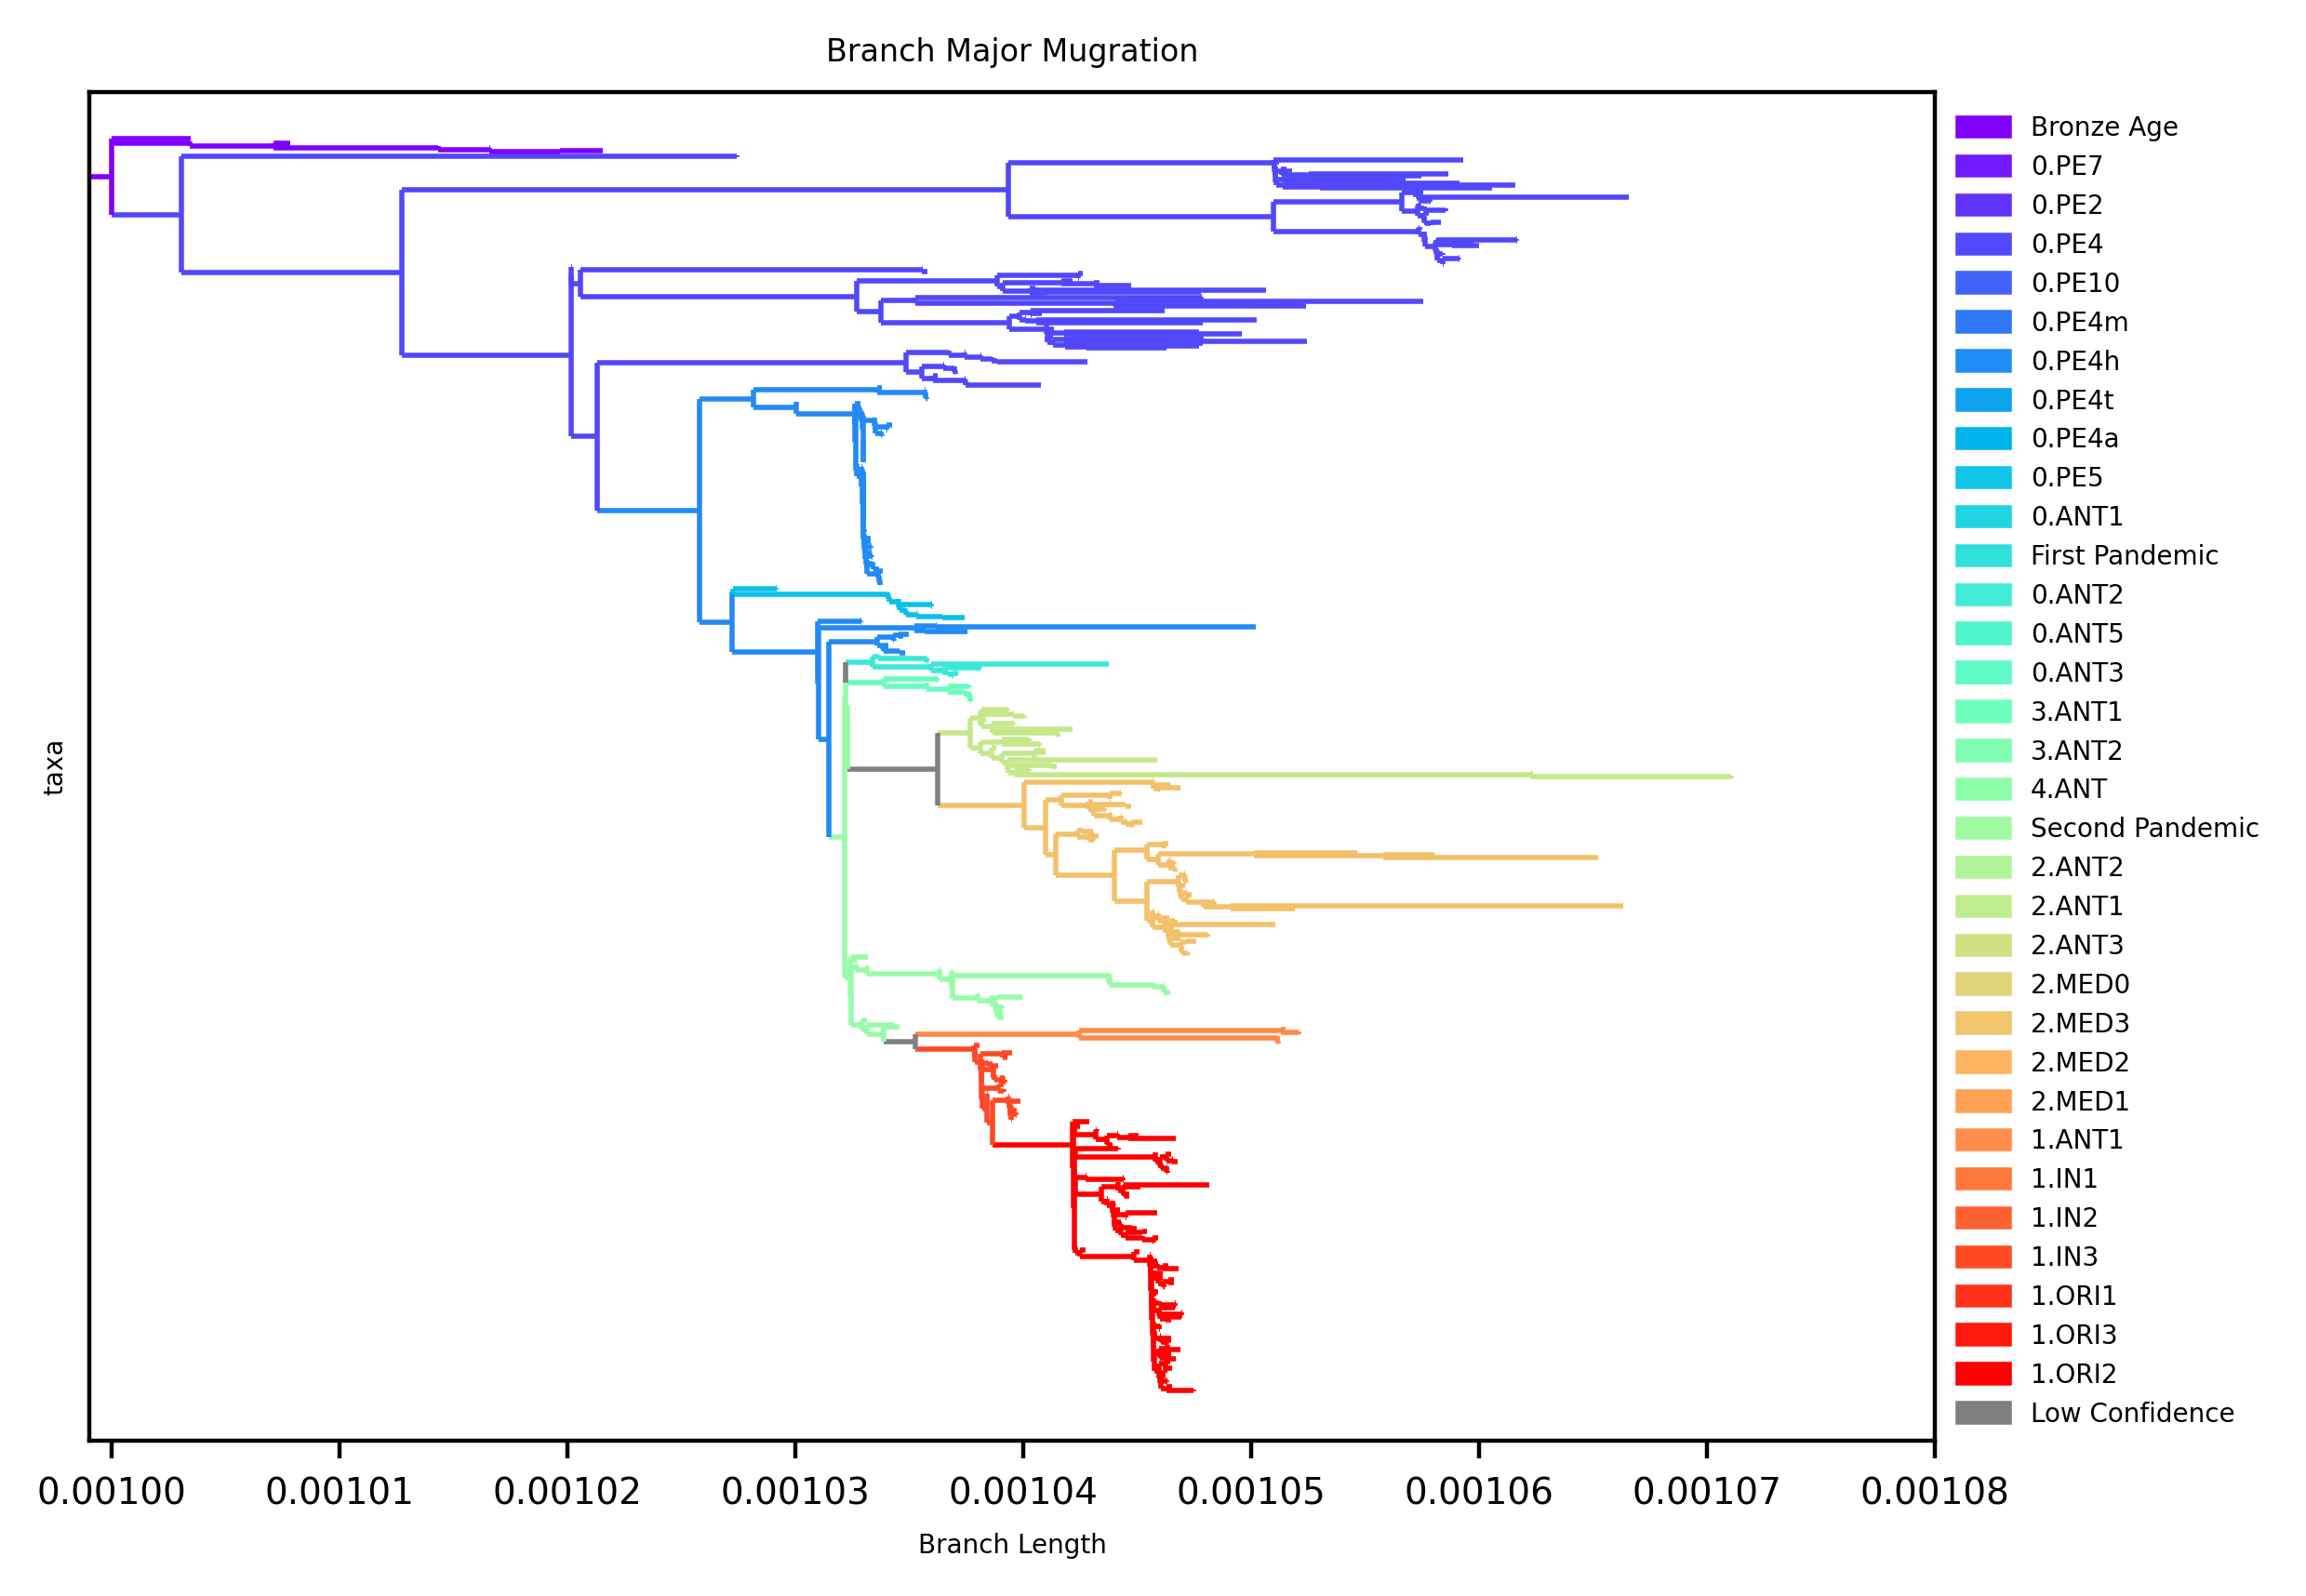

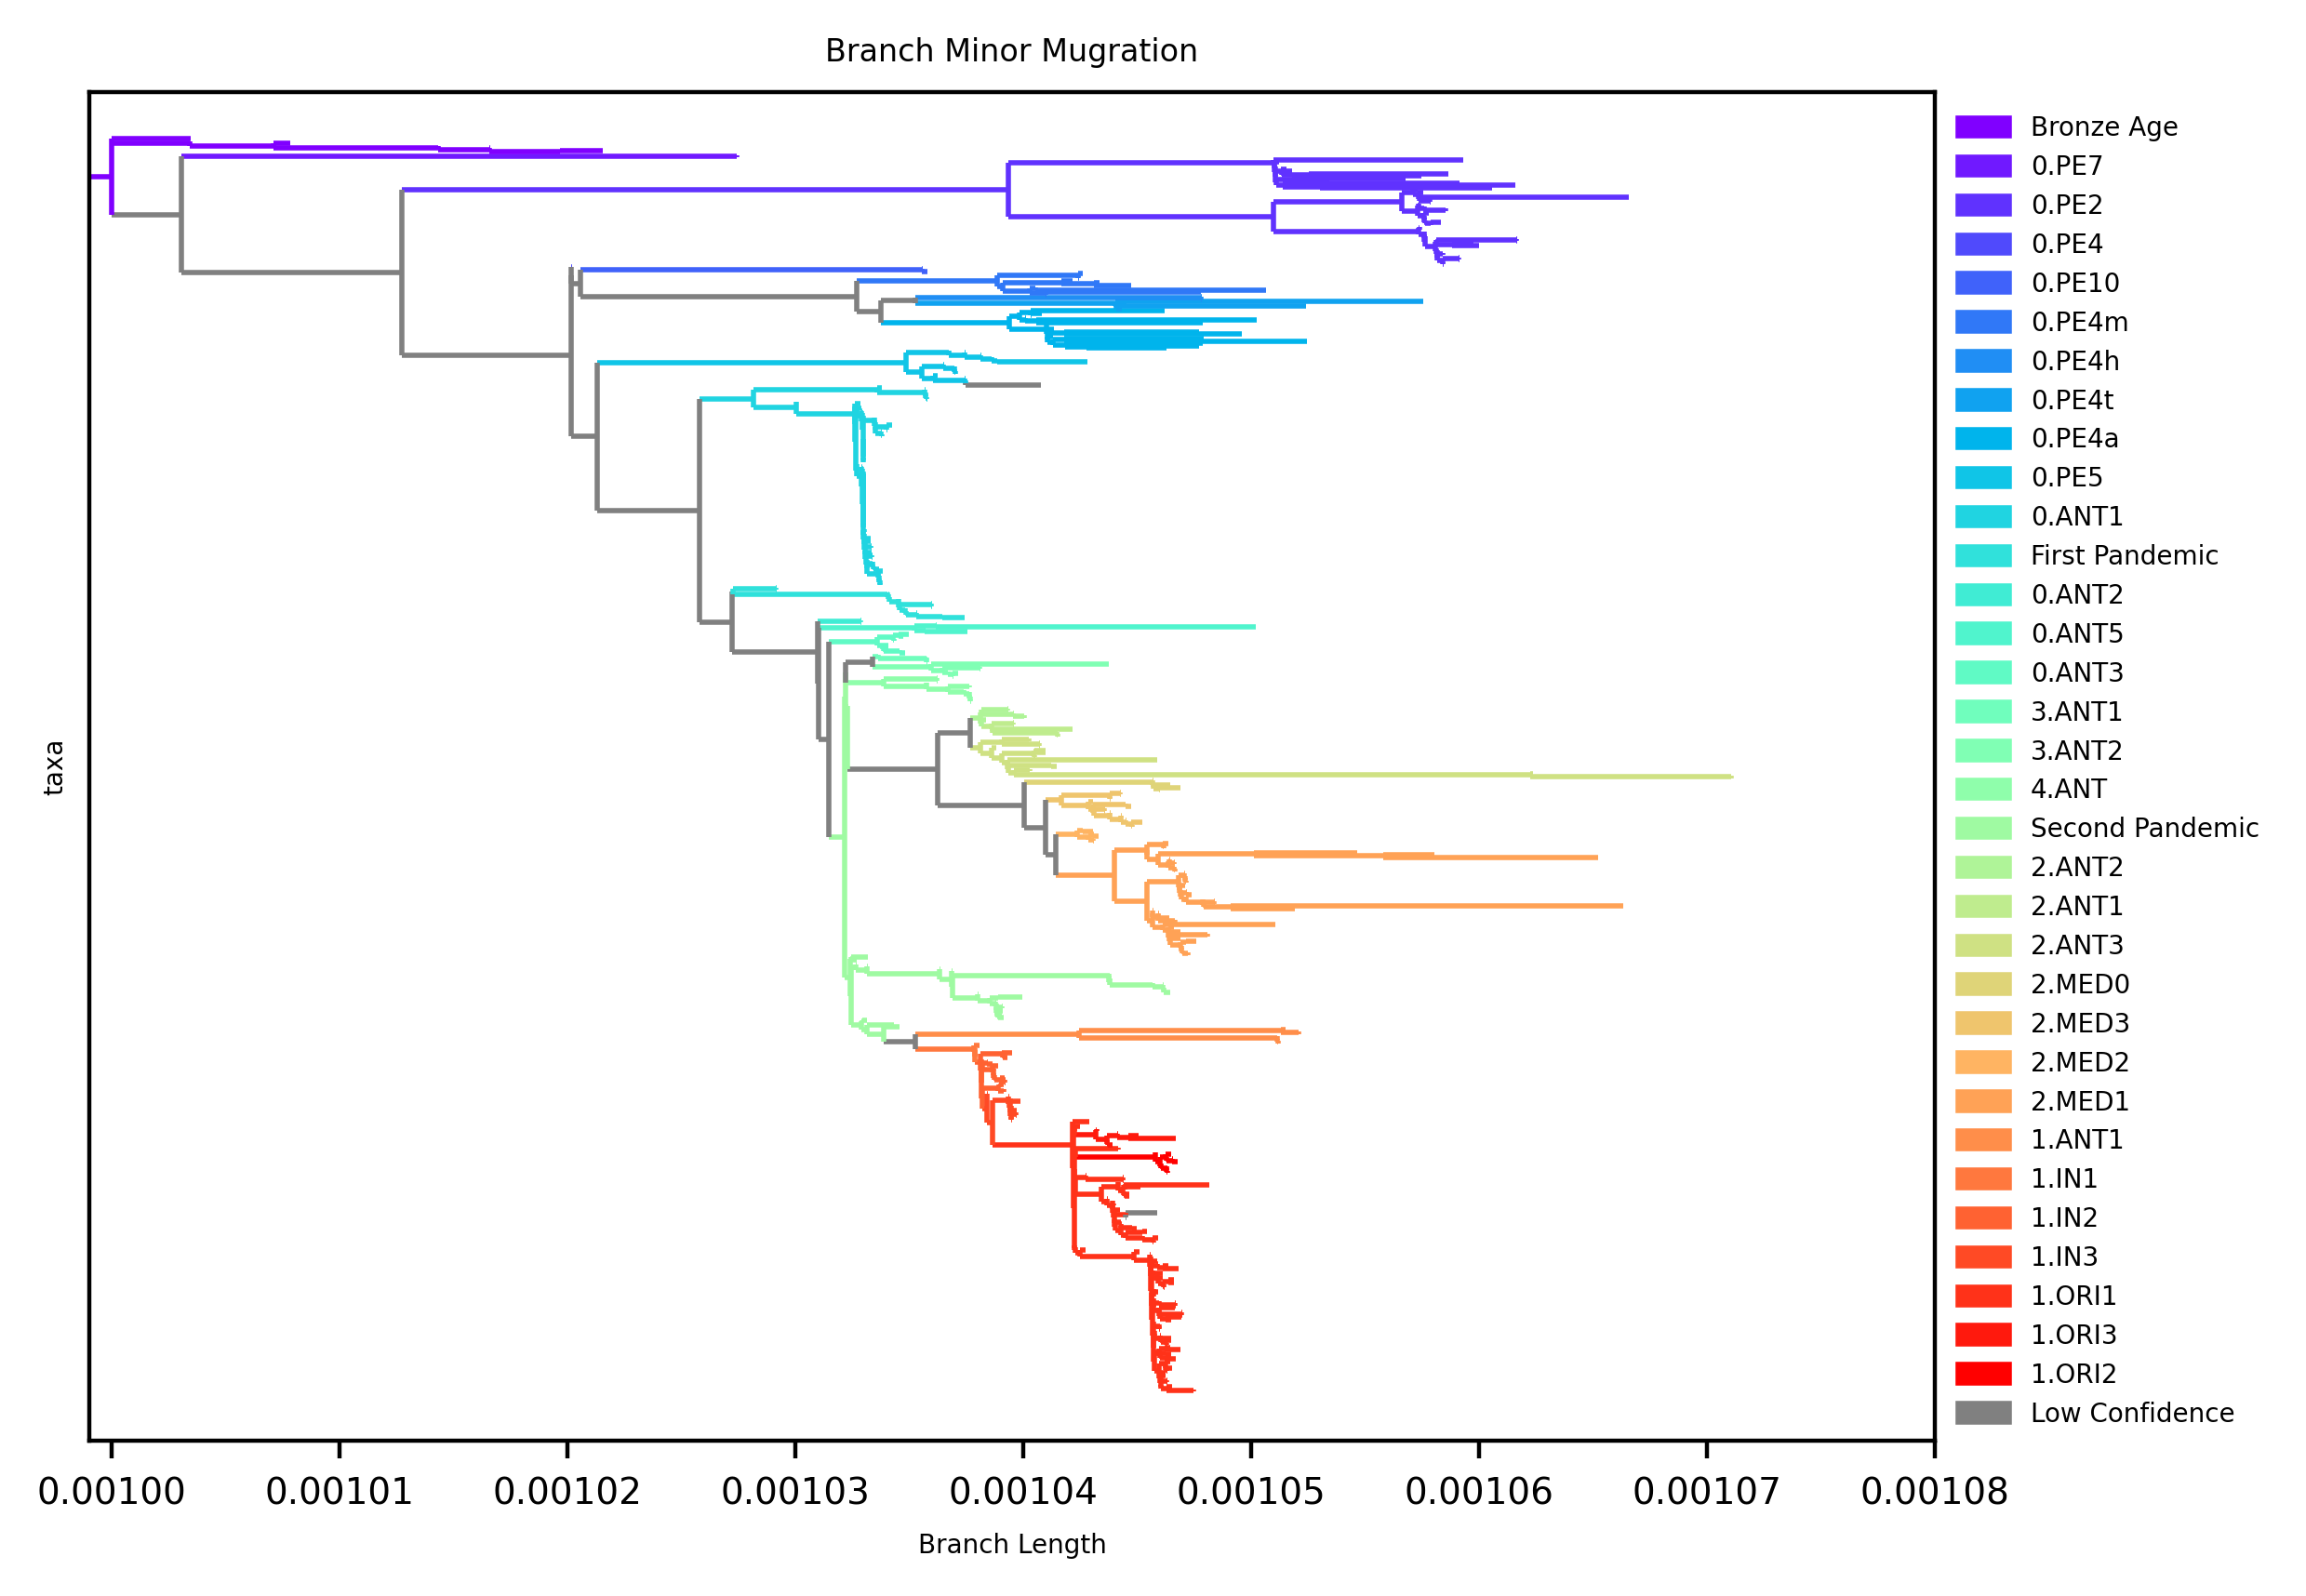

In [86]:
for attr in ATTRIBUTE_LIST:
    
    mug_tree = mug_dict[attr]["tree_mug"].tree
    
    fig = plt.figure(dpi=dpi, figsize=figsize)
    ax = plt.subplot()

    # Deepest nodes first
    mug_tree.ladderize(reverse=True)


    # Draw tree to the canvas
    Phylo.draw(mug_tree, 
               axes=ax, 
               show_confidence=False, 
               label_func = lambda x:'', 
               do_show=False)

    # Root branch length set to 0.001
    # Ticks
    ax.set_xlim(0.000999,0.00108)
    ax.set_ylim(-20,len(mug_tree.get_terminals())+20)
    ax.set_yticks([])
    plt.xticks(fontsize=7)

    # Labels
    plt.xlabel("Branch Length")
    #plt.ylabel("Taxa")
    plt.title("{} Mugration".format(attr.replace("_"," ")))

    # Legend
    legend_elements = [patches.Patch(facecolor=value, edgecolor=value,) for value in hex_dict.values()]
    legend_labels = list(hex_dict.keys())

    ax.legend(legend_elements, 
              legend_labels,
              bbox_to_anchor=(1.0, 1.0), 
              loc='upper left',
              frameon=False,
             )


"""    # Write to file
    out_path = os.path.join(outdir, "treetime_{}_mug_tree.jpg".format(attr.lower()))  
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")"""

### Draw Mugration Confidence Tree

In [ ]:
"""# Deepest nodes last
mug_tree_div.ladderize(reverse=True)

for c in mug_tree_div.find_clades():
    for prop in c.other:
        if prop.namespace == ATTRIBUTE + "_assign":
            # color by confidence
            c.color = "black"
            if float(prop.value) >= MUG_CONF_THRESH:
                c.color = "red"

fig = plt.figure(dpi=400)
ax = plt.subplot()

# Draw tree to the canvas
Phylo.draw(mug_tree_div, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# Root branch length set to 0.001
# Ticks
ax.set_xlim(0.000999,0.00108)
ax.set_ylim(-20,len(mug_tree_div.get_terminals())+20)
ax.set_yticks([])
plt.xticks(fontsize=7)

# Labels
plt.xlabel("Branch Length")
plt.ylabel("Taxa")
plt.title("Mugration {} Confidence".format(ATTRIBUTE))

# Legend
legend_lines = [lines.Line2D([0], [0], color="red", lw=4),
                lines.Line2D([0], [0], color="black", lw=4)]

ax.legend(legend_lines, 
          ["High Confidence)".format(MUG_CONF_THRESH),
           "Low Confidence"],
          bbox_to_anchor=(1.0, 1.0), 
          loc='upper left',)

# Write to file
out_path = os.path.join(outdir, "treetime_{}_mug_conf_tree.jpg".format(ATTRIBUTE.lower()))  
plt.savefig(out_path, dpi=400, bbox_inches = "tight")"""

## Questions

### 2. How much phylogeographic signal is present in the *Yersinia pestis* phylogeny?

In [ ]:
"""# Store terminals in two lists for comparison
term_list = [t for t in tree_div.get_terminals()]
term_list.reverse()

dist_div_list = []
dist_geo_list = []

i = 0
progress_log_breaks = [num for num in range(0,101)]
i_progress = 0

for t1 in term_list:
    
    t1_name = t1.name
    t1_lat = tree_df[ATTRIBUTE_LAT][t1.name]
    t1_lon = tree_df[ATTRIBUTE_LON][t1.name]
    t1_latlon = (t1_lat, t1_lon)
    
    # Skip if natlon is nan
    if t1_lat == "NA" or t1_lon == "NA":
        continue
        
    # Iterate through terminals again for distance measures
    for t2 in term_list:           
        t2_name = t2.name     
        # Skip if it's a self comparison
        if t1_name == t2_name: continue
            
        t2_lat = tree_df[ATTRIBUTE_LAT][t2_name]
        t2_lon = tree_df[ATTRIBUTE_LON][t2_name]
        
        # Skip if latlon is nan
        if t2_lat == "NA" or t2_lon == "NA":
            continue
        t2_latlon = (t2_lat, t2_lon)
       
        # Calculate branch distance (divergence)
        dist_div = tree_div.distance(t1_name, t2_name)  
        # Calculate geographic distance (great circle)
        dist_geo = getattr(great_circle(t1_latlon, t2_latlon), DIST_UNIT)
        dist_div_list.append(dist_div)
        dist_geo_list.append(dist_geo)
    
    # Counter for a progress log since this is slow
    i+=1
    progress = (i / len(term_list)) * 100
    if progress >= progress_log_breaks[i_progress]:
        print("{:0.0f}%".format(progress))
        i_progress += 1
    #if i ==5:
    #    break"""

In [ ]:
"""
# Create a joint plot

g = sns.JointGrid()
g.fig.set_dpi(dpi)

# Main Scatter
#sns.regplot(
sns.scatterplot(
                x=dist_div_list,
                y=dist_geo_list,  
                s=1,
                #scatter_kws = {"s": 0.5}, 
                ax=g.ax_joint,
                #line_kws={"color": "red"}
               )

sns.kdeplot(x=dist_div_list, 
            linewidth=1,
            fill=True,
            ax=g.ax_marg_x,
            #bw_method=0.03,
           )

sns.kdeplot(y=dist_geo_list, 
            linewidth=1,
            fill=True,
            ax=g.ax_marg_y,
            bw_method=0.03,
           )

# Constrain view and limits
g.ax_marg_y.set_ylim(0-500,int(max(dist_geo_list)) + 500)

# Labels and Titles
g.ax_joint.set_xlabel("Genetic Distance (Branch Length)")
g.ax_joint.set_ylabel("Geographic Distance (km)")
g.fig.suptitle("Phylogeographic Signal as Isolation by Distance",
                x=0.5,
                y=1.05)

# Caption
caption_text = ("Pairwise genetic distance (branch length) compared with pariwise geographic distance (greater circle)." 
                + "\nGeographic Resolution: {}".format(ATTRIBUTE)
               )
g.fig.text(0.4, -0.05, caption_text, ha='center')

# Save
out_path = os.path.join(outdir, "treetime_{}_IBD.jpg".format(ATTRIBUTE.lower())) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")"""

### 3. Plot the internal branches after mugration

In [ ]:
# Make a copy of the tree to edit values
mug_tree_div = copy.deepcopy(mug.tree)
# Deepest nodes first
mug_tree_div.ladderize(reverse=False)

# Initialize the states
ordered_states = []

# Get the ladderized order of attributes
for t in mug_tree_div.get_terminals():
    for prop in t.other:
        if prop.namespace == ATTRIBUTE + "_assign" and prop.tag not in ordered_states:
            ordered_states.append(prop.tag)

# Number of states that need colors (exclude nan)
num_attr = len(unique_states[:-1])

# Create the custom color map
cmap = plt.get_cmap(COLOR_PAL,num_attr)
# Convert to a list of colors
cmaplist = [cmap(i) for i in range(cmap.N)]

# force the first color entry to be grey
#cmaplist = [(.5, .5, .5, 1.0)] + cmaplist 
#num_attr = num_attr + 1

# create the new map
cmap = colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, num_attr)

cmaplist = cmap(np.linspace(0, 1, num_attr))
hex_list = [colors.to_hex(col) for col in cmaplist]

hex_dict = {}

# Assign states colors based on tip order (Low Conf first as grey)
for state,hex_col in zip(ordered_states, hex_list):
    hex_dict[state] = hex_col

# OPTIONAL: Add Low confidence grey to colormap
hex_dict["Low Confidence"] = "grey"

# Color branches by attr
for c in mug_tree_div.find_clades():
    for prop in c.other:
        if prop.namespace == ATTRIBUTE + "_assign":
            # Color by category
            c.color = hex_dict[prop.tag]
            # OPTIONAL: Color grey if low confidence
            if float(prop.value) < MUG_CONF_THRESH:
                c.color = "grey"
            
fig = plt.figure(dpi=dpi, figsize=figsize)
ax = plt.subplot()

# Deepest nodes first
mug_tree_div.ladderize(reverse=True)

# Draw tree to the canvas
Phylo.draw(mug_tree_div, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

annot1_node = "SAMN00715800" # 8291 - Black Death

annot_dict = {"Black Death": {"node": "SAMN00715800", "x": 0, "y": 0}}
              
i = 0
for t in mug_tree_div.get_terminals():
    i += 1
    for annot in annot_dict:
        if t.name == annot_dict[annot]["node"]:
            annot_dict[annot]["x"] = mug_tree_div.distance(t, mug_tree_div.root) + 0.001
            annot_dict[annot]["y"] = i
            break

# Now add annotations to plot
y_offset = 0
x_offset = -0.0000080
for annot in annot_dict:
    ax.text(annot_dict[annot]["x"] + x_offset, 
            annot_dict[annot]["y"] + y_offset, 
            annot,)


# Root branch length set to 0.001
# Ticks
ax.set_xlim(0.000999,0.00108)
ax.set_ylim(-20,len(mug_tree_div.get_terminals())+20)
ax.set_yticks([])
plt.xticks(fontsize=7)

# Labels
plt.xlabel("Branch Length")
#plt.ylabel("Taxa")
plt.title("{} Mugration".format(ATTRIBUTE.replace("_"," ")))

# Legend
legend_elements = [patches.Patch(facecolor=value, edgecolor=value,) for value in hex_dict.values()]
legend_labels = list(hex_dict.keys())

ax.legend(legend_elements, 
          legend_labels,
          bbox_to_anchor=(1.0, 1.0), 
          loc='upper left',
          frameon=False,
         )


# Write to file
out_path = os.path.join(outdir, "treetime_{}_mug_tree.jpg".format(ATTRIBUTE.lower()))  
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Geo Experiment

In [ ]:
#import cartopy.crs as ccrs

## Cleanup

In [ ]:
os.remove(tmp_xml)